## Tuning Each Model before Stacking them

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from mlxtend.regressor import StackingCVRegressor

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error as MSE
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import RidgeCV, LinearRegression

In [5]:
df = pd.read_csv("extended_df.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,nbd_price_sqf,nbd_avg_price,SubClass_avg_price,Zoning_avg_price,yearbuilt_avg_price,age_avg_price,age_afterRemodel_price,rooms_avg_price,bldgtype_avg_price,overalcond_avg_price
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,62.038341,197965.773333,65.750673,59.919799,227408.577778,235136.666667,189917.391304,213427.529412,185763.807377,203146.914738
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,68.934594,238772.727273,58.865992,59.919799,163831.969697,168832.419355,163939.464286,161303.296020,185763.807377,155651.736111
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,62.038341,197965.773333,65.750673,59.919799,242630.000000,223333.333333,200525.375000,161303.296020,185763.807377,203146.914738
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,65.396994,210624.725490,56.016462,59.919799,134387.500000,131566.666667,131429.545455,196666.784195,185763.807377,203146.914738
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,70.024933,335295.317073,65.750673,59.919799,210766.666667,211244.000000,209098.809524,252988.173333,185763.807377,203146.914738


In [8]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:
nulls = df.isnull().sum().sort_values(ascending = False)
print(nulls[nulls >0])

MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
GarageType        81
GarageFinish      81
Electrical         1
dtype: int64


In [10]:
values = {"GarageType": "None", "GarageFinish": "None", "MasVnrType": "None", "Electrical": "Mix"}
df.fillna(value=values, inplace = True)

In [12]:
nulls = df.isnull().sum().sort_values(ascending = False)
print(nulls[nulls >0])

MiscFeature    1406
Alley          1369
Fence          1179
dtype: int64


In [14]:
# Define function to add features safely to train and test
def add_poly_features(df):
    df = df.copy()
    df['expected_price'] = df['GrLivArea'] * df['nbd_avg_price']
    df["YearBuilt_total_area"] = df["YearBuilt"] * df["total_area"]
    df['LotFrontage_yearbuilt_avg_price'] = df['LotFrontage'] * df['yearbuilt_avg_price']
    df['OverallQual_GrLivArea'] = df['OverallQual'] * df['GrLivArea']
    df['OverallQual_total_area'] = df['OverallQual'] * df['total_area']
    df['OverallQual_nbd_price_sqf'] = df['OverallQual'] * df['nbd_price_sqf']
    df['OverallQual_rooms_avg_price'] = df['OverallQual'] * df['rooms_avg_price']
    df["OverallCond_total_area"] = df["OverallCond"] * df["total_area"]
    df['OverallCond_age_avg_price'] = df['OverallCond'] * df['age_avg_price']
    df['ExterQual_total_area'] = df['ExterQual'] * df['total_area']
    df['BsmtQual_total_area'] = df['BsmtQual'] * df['total_area']
    df['BsmtQual_nbd_price_sqf'] = df['BsmtQual'] * df['nbd_price_sqf']
    df['BsmtCond_total_area'] = df['BsmtCond'] * df['total_area']
    df['BsmtExposure_2ndFlrSF'] = df['BsmtExposure'] * df['2ndFlrSF']
    df['BsmtExposure_GrLivArea'] = df['BsmtExposure'] * df['GrLivArea']
    df['BsmtFinSF1_nbd_avg_price'] = df['BsmtFinSF1'] * df['nbd_avg_price']
    df['BsmtFinType2_FullBath'] = df['BsmtFinType2'] * df['FullBath']
    df['BsmtFinType2_age_avg_price'] = df['BsmtFinType2'] * df['age_avg_price']
    df['HeatingQC_total_area'] = df['HeatingQC'] * df['total_area']
    df['CentralAir_total_area'] = df['CentralAir'] * df['total_area']
    df['1stFlrSF_age_avg_price'] = df['1stFlrSF'] * df['age_avg_price']
    df['2ndFlrSF_yearbuilt_avg_price'] = df['2ndFlrSF'] * df['yearbuilt_avg_price']
    df['GrLivArea_nbd_avg_price'] = df['GrLivArea'] * df['nbd_avg_price']
    df['GrLivArea_yearbuilt_avg_price'] = df['GrLivArea'] * df['yearbuilt_avg_price']
    df['GrLivArea_age_avg_price'] = df['GrLivArea'] * df['age_avg_price']
    df['BsmtFullBath_yearbuilt_avg_price'] = df['BsmtFullBath'] * df['yearbuilt_avg_price']
    df['KitchenQual_total_area'] = df['KitchenQual'] * df['total_area']
    df['Fireplaces_yearbuilt_avg_price'] = df['Fireplaces'] * df['yearbuilt_avg_price']
    df['Fireplaces_age_afterRemodel_price'] = df['Fireplaces'] * df['age_afterRemodel_price']
    df['total_area_nbd_price_sqf'] = df['total_area'] * df['nbd_price_sqf']
    df['total_area_nbd_avg_price'] = df['total_area'] * df['nbd_avg_price']
    df['total_area_SubClass_avg_price'] = df['total_area'] * df['SubClass_avg_price']
    df['total_area_Zoning_avg_price'] = df['total_area'] * df['Zoning_avg_price']
    df['total_area_yearbuilt_avg_price'] = df['total_area'] * df['yearbuilt_avg_price']
    df['total_area_age_avg_price'] = df['total_area'] * df['age_avg_price']
    df['total_area_age_afterRemodel_price'] = df['total_area'] * df['age_afterRemodel_price']
    df['total_area_overalcond_avg_price'] = df['total_area'] * df['overalcond_avg_price']
    df['total_bathrooms_nbd_avg_price'] = df['total_bathrooms'] * df['nbd_avg_price']
    df['total_bathrooms_age_avg_price'] = df['total_bathrooms'] * df['age_avg_price']
    df['total_bathrooms_age_afterRemodel_price'] = df['total_bathrooms'] * df['age_afterRemodel_price']
    df['nbd_price_sqf_age_avg_price'] = df['nbd_price_sqf'] * df['age_avg_price']
    df['nbd_avg_price_rooms_avg_price'] = df['nbd_avg_price'] * df['rooms_avg_price']
    df["LotArea_nbd_avg_price"] = df["LotArea"] * df["nbd_avg_price"]
    df["LotArea_age_avg_price"] = df['LotArea'] * df['age_avg_price']

    return df

In [16]:
X = df.drop(['SalePrice', 'price_sqft', 'Id'], axis = 1)
X = X.dropna(axis = 1)
y = df['SalePrice']

X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = add_poly_features(X_train_full)
X_test = add_poly_features(X_test_full)

## Preprocessing Pipeline

In [19]:
num_features = X.select_dtypes(include="number").columns.to_list()
cat_features = X.select_dtypes(include=["object", "category"]).columns.to_list()

In [21]:
preprocessor = ColumnTransformer(
    transformers = [
        ('scaler', StandardScaler(), num_features),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False), cat_features)
    ])

## Tuning Models

### XGBoost

In [19]:
# full pipeline
xgb_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective = 'reg:squarederror', random_state = 42, n_jobs = -1,verbosity = 0))
])

# tuning XGBoost
param_grid = {
    'model__n_estimators': [300, 500], # 3
    'model__learning_rate': np.arange(0.03, 0.0781, 0.004), #11 values
    'model__max_depth': [2, 3, 4, 5] # 4
}

In [20]:
# Set up GridSearchCV
grid_search = GridSearchCV(xgb_pipeline, param_grid,
    scoring = 'neg_mean_absolute_error',  
    cv = 5,
    verbose = 1,
    n_jobs = -1
)

In [21]:
# Fit on training data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best MAE:", -grid_search.best_score_)

Fitting 5 folds for each of 104 candidates, totalling 520 fits
Best parameters: {'model__learning_rate': 0.058000000000000024, 'model__max_depth': 3, 'model__n_estimators': 500}
Best MAE: 14848.941660677112


##### Plot the results

In [36]:
# Create DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Convert negative MAE to positive
results['mean_absolute_error'] = -results['mean_test_score']

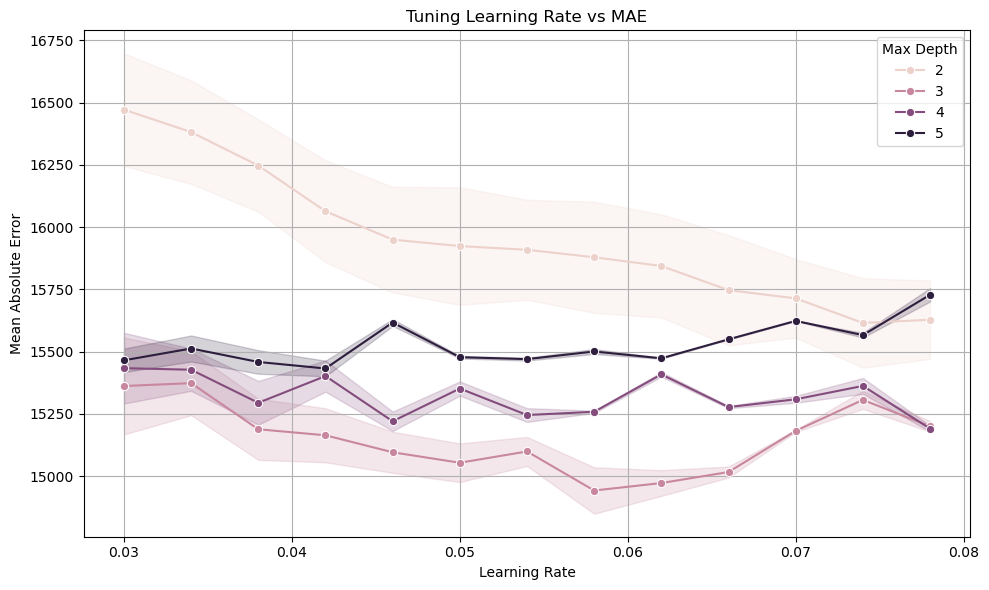

In [37]:
# Line plot of learning_rate vs MAE, colored by max_depth
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, 
             x='param_model__learning_rate', 
             y='mean_absolute_error', 
             hue='param_model__max_depth',
             marker='o')
plt.title('Tuning Learning Rate vs MAE')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Learning Rate')
plt.legend(title='Max Depth')
plt.grid(True)
plt.tight_layout()
plt.show()

### LightGBM

In [39]:
# full pipeline
lgbm_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state = 42, n_jobs = 4, verbose = 0))
])

#parameters of gridsearchcv
param_grid_lgbm = {
    'model__n_estimators': [250, 500],
    'model__learning_rate': np.arange(0.03, 0.0581, 0.002),
    'model__max_depth': [2, 3, 4]
}

In [40]:
#gridsearch and print the best parameters
grid_lgbm = GridSearchCV(lgbm_pipeline, param_grid_lgbm,
    scoring = 'neg_mean_absolute_error',
    cv = 5,
    n_jobs = -1,
    verbose = 1
)

grid_lgbm.fit(X_train, y_train)
print("LightGBM best:", grid_lgbm.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [41]:
print("Best MAE:", -grid_lgbm.best_score_)

Best MAE: 15146.412274135864


##### Plot the results

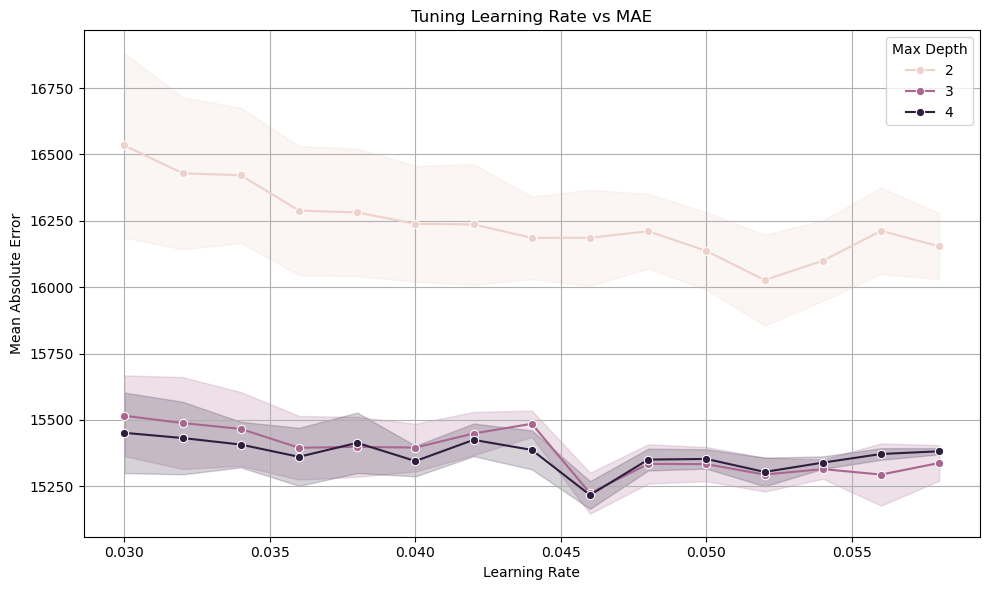

In [43]:
# Create DataFrame
results = pd.DataFrame(grid_lgbm.cv_results_)

# Convert negative MAE to positive
results['mean_absolute_error'] = -results['mean_test_score']

# Line plot of learning_rate vs MAE, colored by max_depth
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, 
             x='param_model__learning_rate', 
             y='mean_absolute_error', 
             hue='param_model__max_depth',
             marker='o')
plt.title('Tuning Learning Rate vs MAE')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Learning Rate')
plt.legend(title='Max Depth')
plt.grid(True)
plt.tight_layout()
plt.show()

### BaggingRegressor

In [45]:
bag_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', BaggingRegressor(random_state=42, n_jobs=-1))
])

param_grid_bag = {
    'model__n_estimators': [100, 150, 200, 250],
    'model__max_samples': [0.6, 0.8, 1.0]
}

grid_bag = GridSearchCV(bag_pipeline, param_grid_bag,
    scoring = 'neg_mean_absolute_error',
    cv = 5,
    n_jobs = -1,
    verbose = 1
)

grid_bag.fit(X_train, y_train)
print("Bagging best:", grid_bag.best_params_)
print("Best MAE:", -grid_bag.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Bagging best: {'model__max_samples': 1.0, 'model__n_estimators': 250}
Best MAE: 16829.20708518396


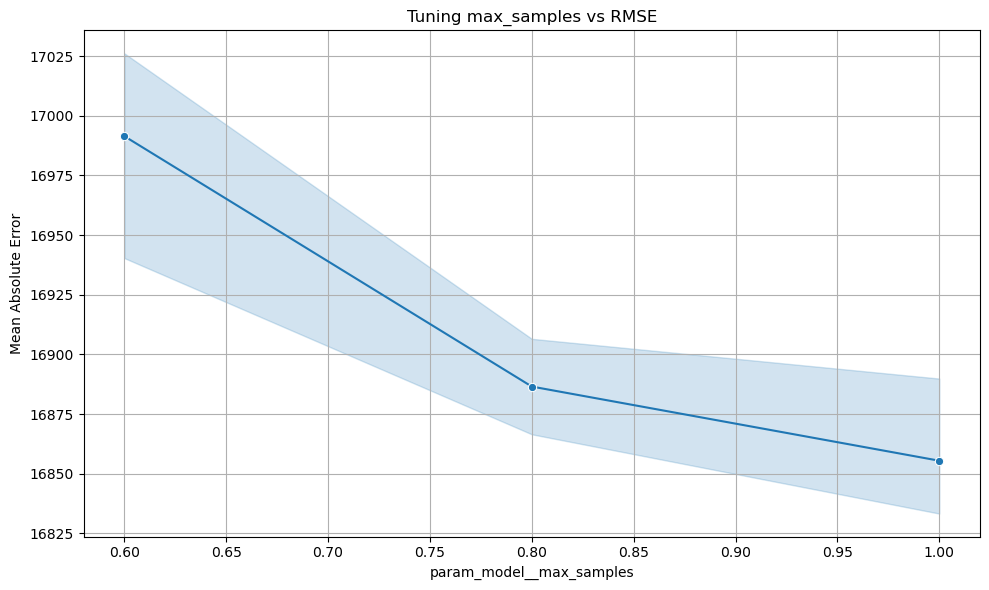

In [46]:
# Create DataFrame
results = pd.DataFrame(grid_bag.cv_results_)

# Convert negative MAE to positive
results['mean_absolute_error'] = -results['mean_test_score']

plt.figure(figsize=(10, 6))
sns.lineplot(data=results, 
             x='param_model__max_samples', 
             y='mean_absolute_error', 
             marker='o')
plt.title('Tuning max_samples vs RMSE')
plt.ylabel('Mean Absolute Error')
plt.grid(True)
plt.tight_layout()
plt.show()

### RandomForest

In [73]:
rf_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators = 500, random_state = 42, n_jobs = -1))
])

param_grid_rf = {
    'model__max_features': ['sqrt', 'log2', None, 1.0],
    'model__max_depth': [10, 12, 20, 23]
}

grid_rf = GridSearchCV(rf_pipeline,
    param_grid = param_grid_rf,
    scoring = 'neg_mean_absolute_error',
    cv = 5,
    n_jobs = -1,
    verbose = 1
)

grid_rf.fit(X_train, y_train)
print("RandomForest best:", grid_rf.best_params_)
print("Best MAE:", -grid_rf.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
RandomForest best: {'model__max_depth': 20, 'model__max_features': 'sqrt'}
Best MAE: 16606.722384814617


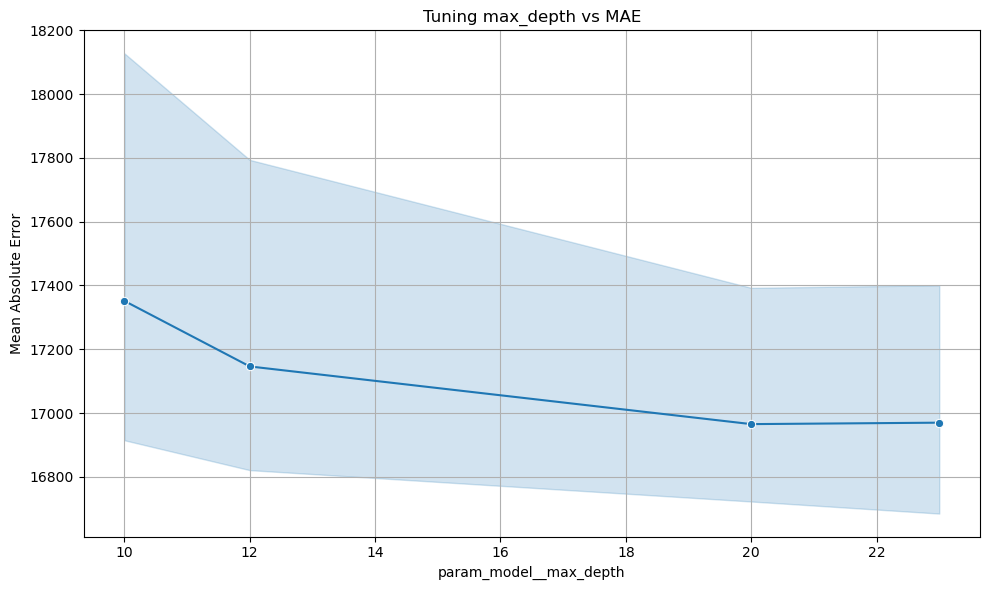

In [39]:
# Create DataFrame
results = pd.DataFrame(grid_rf.cv_results_)

# Convert negative MAE to positive
results['mean_absolute_error'] = -results['mean_test_score']

plt.figure(figsize=(10, 6))
sns.lineplot(data=results, 
             x='param_model__max_depth', 
             y='mean_absolute_error', 
             marker='o')
plt.title('Tuning max_depth vs MAE')
plt.ylabel('Mean Absolute Error')
plt.grid(True)
plt.tight_layout()
plt.show()

### catBoost

In [42]:
cat_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(random_state=42))
])

param_grid_cat = {
    'model__depth': [5, 8, 10],
    'model__learning_rate': np.arange(0.02, 0.044, 0.002)
}

grid_cat = GridSearchCV(cat_pipeline, param_grid_cat,
    scoring = 'neg_mean_absolute_error',
    cv = 5,
    n_jobs = -1,
    verbose = 1
)

grid_cat.fit(X_train, y_train)
print("CatBoost best:", grid_cat.best_params_)
print("Best MAE:", -grid_cat.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0:	learn: 75659.9154315	total: 171ms	remaining: 2m 50s
1:	learn: 74172.2381847	total: 190ms	remaining: 1m 34s
2:	learn: 72797.2163825	total: 206ms	remaining: 1m 8s
3:	learn: 71440.3087456	total: 223ms	remaining: 55.5s
4:	learn: 69959.9864606	total: 237ms	remaining: 47.2s
5:	learn: 68620.8606808	total: 256ms	remaining: 42.4s
6:	learn: 67394.7429435	total: 274ms	remaining: 38.9s
7:	learn: 66101.9893292	total: 290ms	remaining: 36s
8:	learn: 64739.2674234	total: 315ms	remaining: 34.6s
9:	learn: 63464.1413375	total: 334ms	remaining: 33.1s
10:	learn: 62386.0859767	total: 360ms	remaining: 32.4s
11:	learn: 61178.2481256	total: 379ms	remaining: 31.2s
12:	learn: 60018.1555784	total: 408ms	remaining: 30.9s
13:	learn: 58927.0608569	total: 426ms	remaining: 30s
14:	learn: 57824.6116603	total: 439ms	remaining: 28.8s
15:	learn: 56851.0591432	total: 451ms	remaining: 27.7s
16:	learn: 55870.5782478	total: 467ms	remaining: 27s
17:	learn: 54955.